# Lesson 4. Crop Spatial Raster Data With a Shapefile in Python

Learning Objectives
- Crop a raster dataset in Python using a vector extent object derived from a shapefile.
- Open a shapefile in Python.

In previous lessons, you reclassified a raster in Python; however, the edges of your raster dataset were uneven.

In this lesson, you will learn how to crop a raster - to create a new raster object / file that you can share with colleagues and / or open in other tools such as a Desktop GIS tool like QGIS.

## About Spatial Crop
**Cropping (sometimes also referred to as clipping**), is when you subset or **make a dataset smaller, by removing all data outside of the crop area or spatial extent**. In this case you have a large raster - but let’s pretend that you only need to work with a smaller subset of the raster.

You can use the crop_image function to remove all of the data outside of your study area. This is useful as it:

- Makes the data smaller and
- Makes processing and plotting faster

In [17]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from shapely.geometry import mapping
import rioxarray as rxr
import xarray as xr
import geopandas as gpd
from matplotlib.colors import ListedColormap, BoundaryNorm

import earthpy as et
import earthpy.plot as ep

# Prettier plotting with seaborn
sns.set(font_scale=1.5)

# Get data and set working directory
et.data.get_data("colorado-flood")
os.chdir(os.path.join(et.io.HOME,
                      'earth-analytics',
                      'data'))

### Open Raster and Vector Layers

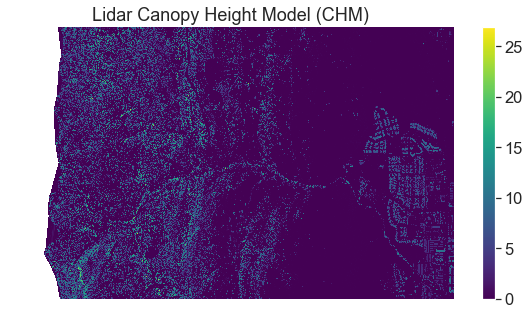

In [2]:
lidar_chm_path = os.path.join("colorado-flood", 
                              "spatial"
                              "boulder-leehill-rd",
                              "outputs",
                              "lidar_chm.tif")

lidar_chm_im = rxr.open_rasterio("colorado-flood/spatial/boulder-leehill-rd/outputs/lidar_chm.tif",
                                 masked=True).squeeze()

f, ax = plt.subplots(figsize=(10, 5))
lidar_chm_im.plot.imshow()
ax.set(title="Lidar Canopy Height Model (CHM)")

ax.set_axis_off()
plt.show()

### Open Vector Layer

In [3]:
aoi = os.path.join("colorado-flood",
                   "spatial",
                   "boulder-leehill-rd",
                   "clip-extent.shp")

# Open crop extent (your study area extent boundary)
crop_extent = gpd.read_file(aoi)

In [4]:
print('crop extent crs: ', crop_extent.crs)
print('lidar crs: ', lidar_chm_im.rio.crs)

crop extent crs:  epsg:32613
lidar crs:  EPSG:32613


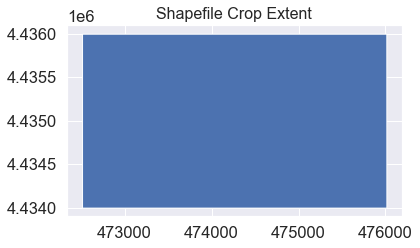

In [5]:
# Plot the crop boundary layer
# Note this is just an example so you can see what it looks like
# You don't need to plot this layer in your homework!
fig, ax = plt.subplots(figsize=(6, 6))

crop_extent.plot(ax=ax)

ax.set_title("Shapefile Crop Extent",
             fontsize=16)
plt.show()

Now that you have imported the shapefile. You can use the crop_image function from earthpy.spatial to crop the raster data using the vector shapefile.

Now that you have imported the shapefile. You can use the crop_image function from earthpy.spatial to crop the raster data using the vector shapefile.

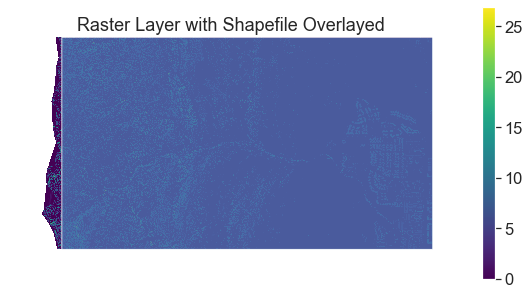

In [6]:
f, ax = plt.subplots(figsize=(10, 5))
lidar_chm_im.plot.imshow(ax=ax)

crop_extent.plot(ax=ax,
                 alpha=.8)
ax.set(title="Raster Layer with Shapefile Overlayed")

ax.set_axis_off()
plt.show()

## Clip Raster Data Using RioXarray .clip
If you want to crop the data you can use the **rio.clip** function. When you clip the data, you can then export it and share it with colleagues. Or use it in another analysis.

To perform the clip you:

- Open the raster dataset that you wish to crop using xarray or rioxarray.
- Open your shapefile as a geopandas object.
- Crop the data using the .clip() function.

.clip has several parameters that you can consider including

- drop = True : The default. setting it will drop all pixels outside of the clip extent
- invert = False : The default. If set to true it will clip all data INSIDE of the clip extent
- crs : if your shapefile is in a different CRS than the raster data, pass the CRS to ensure the data are clipped correctly.

Below you clip the data to the extent of the AOI geodataframe imported above. The data are then plotted.

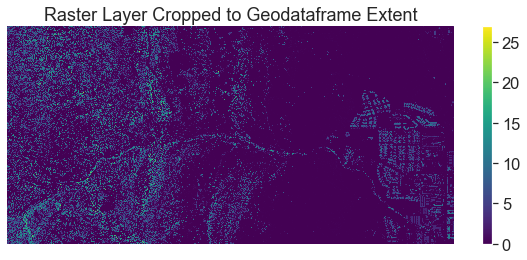

In [7]:
lidar_clipped = lidar_chm_im.rio.clip(crop_extent.geometry.apply(mapping),
                                      # This is needed if your GDF is in a diff CRS than the raster data
                                      crop_extent.crs)

f, ax = plt.subplots(figsize=(10, 4))
lidar_clipped.plot(ax=ax)
ax.set(title="Raster Layer Cropped to Geodataframe Extent")
ax.set_axis_off()
plt.show()

## OPTIONAL – Export Newly Cropped Raster
Once you have cropped your data, you may want to export it to a new geotiff file, just like you did in previous lessons.

You can so this using rioxarray too!

In [12]:
path_to_tif_file = "C:/capes_sql/colorado-flood/outputs/lidar_chm_cropped.tif"

# Write the data to a new geotiff file
lidar_clipped.rio.to_raster(path_to_tif_file)

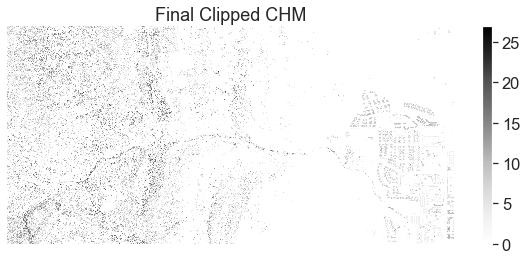

In [13]:
# Open the data you wrote out above
clipped_chm = rxr.open_rasterio(path_to_tif_file)

# Customize your plot as you wish!
f, ax = plt.subplots(figsize=(10, 4))
clipped_chm.plot(ax=ax,
                 cmap='Greys')
ax.set(title="Final Clipped CHM")
ax.set_axis_off()
plt.show()

## Optional Challenge: Crop Change Over Time Layers

Create the same plots except this time CROP each of the rasters that you plotted using the shapefile: data/week-03/boulder-leehill-rd/crop_extent.shp

In [20]:
path_to_tif_file = "C:/capes_sql/colorado-flood/outputs/changes_flood_ch_class_ma.tif"
changes_flood_ch_class_ma = rxr.open_rasterio(path_to_tif_file, masked=True).squeeze()

In [24]:
# clip raster using rioxarray
changes_flood_clipped = changes_flood_ch_class_ma.rio.clip(crop_extent.geometry.apply(mapping),
                                      # This is needed if your GDF is in a diff CRS than the raster data
                                      crop_extent.crs)

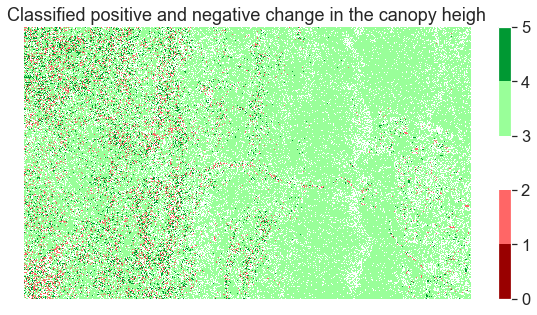

In [25]:
# Plot data using nicer colors
colors = ['#990000', '#ff6666', '#ffffff', '#99ff99', '#009933' ]
class_bins = [0, 1, 2, 3 , 4, 5]
cmap = ListedColormap(colors)
norm = BoundaryNorm(class_bins, 
                    len(colors))

# Plot newly classified and masked raster
f, ax = plt.subplots(figsize=(10, 5))
changes_flood_clipped.plot.imshow(cmap=cmap,
                                   norm=norm) 
ax.set(title="Classified positive and negative change in the canopy heigh")
ax.set_axis_off()
plt.show()


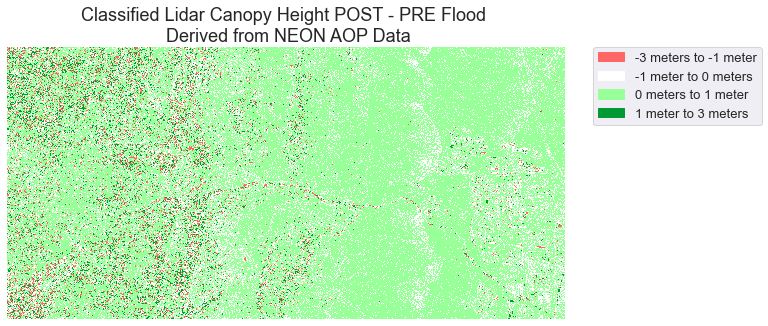

In [26]:
# Create a list of labels to use for your legend
height_class_labels = [
                       "-3 meters to -1 meter",
                       "-1 meter to 0 meters",
                       "0 meters to 1 meter",
                       "1 meter to 3 meters"                      
                      ]

cmap = ListedColormap(colors)
class_bins = [0, 1, 2, 3 , 4, 5]

norm = BoundaryNorm(class_bins,
                    len(colors))

# Plot newly classified and masked raster
f, ax = plt.subplots(figsize=(10, 5))
im = changes_flood_clipped.plot.imshow(cmap=cmap,
                                        norm=norm,
                                        # Turn off colorbar
                                        add_colorbar=False)
# Add legend using earthpy
ep.draw_legend(im,
               titles=height_class_labels)
ax.set(title="Classified Lidar Canopy Height POST - PRE Flood \n Derived from NEON AOP Data")
ax.set_axis_off()